In [ ]:
import mne
import numpy as np
import MARBLE
from MARBLE import postprocessing, plotting

# Selected files
selected_files = [
    # "24_08_13-D_14_36_48_bipolar.fif",
    "24_08_13-D_14_49_45_bipolar.fif",
    # "24_08_13-D_15_00_00_bipolar.fif",
    # "24_08_13-D_16_57_44_bipolar.fif",
    # "24_08_13-D_18_43_55_bipolar.fif",
    # "24_08_13-D_20_00_00_bipolar.fif",
    # "24_08_14-D_11_17_03_bipolar.fif",
    # "24_08_14-D_12_00_00_bipolar.fif",
    # "24_08_14-D_13_00_00_bipolar.fif",
    # "24_08_14-D_15_00_00_bipolar.fif",
]

# Load and format data
pos_list = []
x_list = []
for file in selected_files:
    raw = mne.io.read_raw_fif('./preprocessed/bipolar/'+file, preload=True,verbose=False)
    data = raw.get_data().T
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    # print(data)
    pos_list.append(data[:-1, :])
    x_list.append(np.diff(data, axis=0))

# Construct dataset
data = MARBLE.construct_dataset(anchor=pos_list, vector=x_list,spacing=0.03)

# Train model
params = {
    "epochs": 100,
    "order": 1,
    "hidden_channels": [64],
    "batch_size":512,
    "lr":1e-4,
    "out_channels": 3,
    "inner_product_features": False,
    "emb_norm": True,
    "diffusion": True,
}
model = MARBLE.net(data, params=params)
model.fit(data)

/tmp/ipykernel_623718/1620048997.py:24: RuntimeWarning: This filename (./preprocessed/bipolar/24_08_13-D_14_49_45_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('./preprocessed/bipolar/'+file, preload=True,verbose=False)



---- Embedding dimension: 6
---- Signal dimension: 6
---- Computing kernels ... 
---- Computing full spectrum ...
              (if this takes too long, then run construct_dataset()
              with number_of_eigenvectors specified) 
---- Settings: 

epochs : 100
order : 1
hidden_channels : [64]
lr : 0.0001
out_channels : 3
inner_product_features : False
emb_norm : True
diffusion : True
batch_size : 64
momentum : 0.9
dropout : 0.0
batch_norm : batch_norm
bias : True
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
seed : 0
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  42
---- Total number of parameters:  3076

Using device cuda:0

---- Training network ...

---- Timestamp: 20250310-162631

Epoch: 0, Training loss: 1.422384, Validation loss: 1.4324, lr: 0.0001 *
Epoch: 1, Training loss: 1.400108, Validation loss: 1.4005, lr: 0.0001 *
Epoch: 2, Training loss: 1.387819, Validation loss: 1.3874, lr: 0.0001 *

UnboundLocalError: local variable 'gamma' referenced before assignment

Performed tsne embedding on embedded results.


<Axes: >

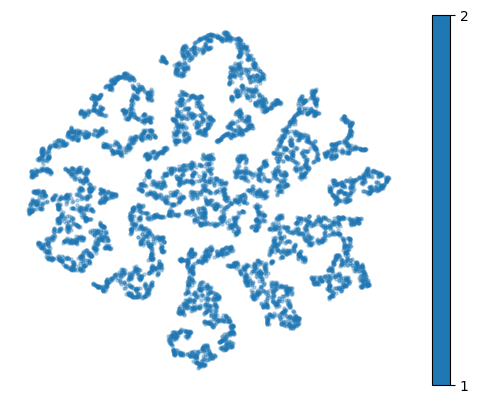

In [17]:
data = model.transform(data)
# data = postprocessing.distribution_distances(data)
data = postprocessing.embed_in_2D(data, embed_typ="tsne")
data = postprocessing.cluster(data, n_clusters=10)